#For Proper Visualization Github Link:
https://github.com/ColdWistler/SyntheticDataAnalytics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import StratifiedKFold # For stratified splitting
from sklearn.preprocessing import OneHotEncoder, StandardScaler # For OHE and scaling
from sklearn.pipeline import Pipeline # To chain preprocessing steps
from sklearn.compose import ColumnTransformer # To apply different transformers to different columns
import torch.nn.functional as F

sns.set(style="whitegrid")

In [ ]:
student_df = pd.read_csv("/content/Student_Records.csv")
school_df = pd.read_csv("/content/School_Info.csv")

In [ ]:
# Fill missing attendance rate with median
student_df["Attendance_Rate"] = student_df["Attendance_Rate"].fillna(student_df["Attendance_Rate"].median())

# Fill missing library status with mode
school_df["Library_Status"] = school_df["Library_Status"].fillna(school_df["Library_Status"].mode()[0])

In [ ]:
z_scores = np.abs(stats.zscore(student_df[["Attendance_Rate", "Previous_Year_GPA"]]))
outlier_mask = (z_scores > 3).any(axis=1)
print(f"Outliers removed: {outlier_mask.sum()}")
student_df = student_df[~outlier_mask]

Outliers removed: 0


In [ ]:
df = pd.merge(student_df, school_df, on="School_ID", how="left")

In [ ]:
categorical_cols = ["Gender", "Socioeconomic_Status", "District", "Location_Type",
                    "Electricity_Access", "Internet_Access", "Library_Status"]
num_cols = ["Grade", "Attendance_Rate", "Previous_Year_GPA", "Infrastructure_Score"]
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handles missing Attendance_Rate
    ('scaler', StandardScaler())
])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' for robustness against unseen categories
])

In [ ]:
# Combine transformers using ColumnTransformer
# This will apply the correct transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep any other columns not specified (e.g., School_ID if you want to keep it)
)

In [ ]:
X = df.drop(columns=['Student_ID', 'School_ID', 'Dropout_Status']) # Convert to numpy array early if needed for ColumnTransformer
y = df['Dropout_Status'].apply(lambda x: 1 if x == 'Y' else 0).values # Convert target to numeric numpy array

print(f"Type of X AFTER conversion: {type(X)}")
print(f"Shape of X AFTER conversion: {X.shape}")

Type of X AFTER conversion: <class 'pandas.core.frame.DataFrame'>
Shape of X AFTER conversion: (600000, 11)


In [ ]:
# Merge school info into students for modeling
merged_df = pd.merge(student_df, school_df, on="School_ID", how="left")

# Check shape
merged_df.head()

,Student_ID,School_ID,Grade,Gender,Socioeconomic_Status,Attendance_Rate,Previous_Year_GPA,Dropout_Status,District,Location_Type,Infrastructure_Score,Electricity_Access,Internet_Access,Library_Status
0,STU00001,SCH2881,9,F,Medium,68.2,2.24,N,Nawalparasi (West),Rural,1.0,N,N,N
1,STU00002,SCH4626,6,M,Low,60.7,1.66,N,Banke,Rural,3.8,N,Y,N
2,STU00003,SCH1729,6,F,Low,52.2,3.48,Y,Arghakhanchi,Rural,2.9,N,N,N
3,STU00004,SCH4818,8,M,Medium,70.9,2.51,N,Arghakhanchi,Rural,1.6,N,Y,N
4,STU00005,SCH4912,2,M,Low,49.3,1.57,N,Palpa,Rural,3.8,Y,Y,Y



--- Performing Exploratory Data Analysis (EDA) ---


/tmp/ipython-input-12-2949367057.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Dropout_Status_Label', data=df_eda, palette='pastel')


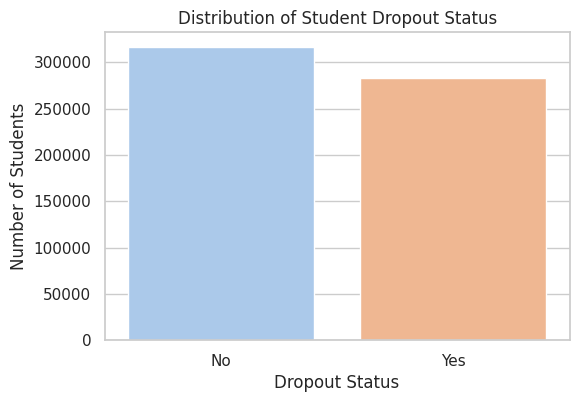

/tmp/ipython-input-12-2949367057.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Socioeconomic_Status', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='viridis')
/tmp/ipython-input-12-2949367057.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Socioeconomic_Status', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='viridis')


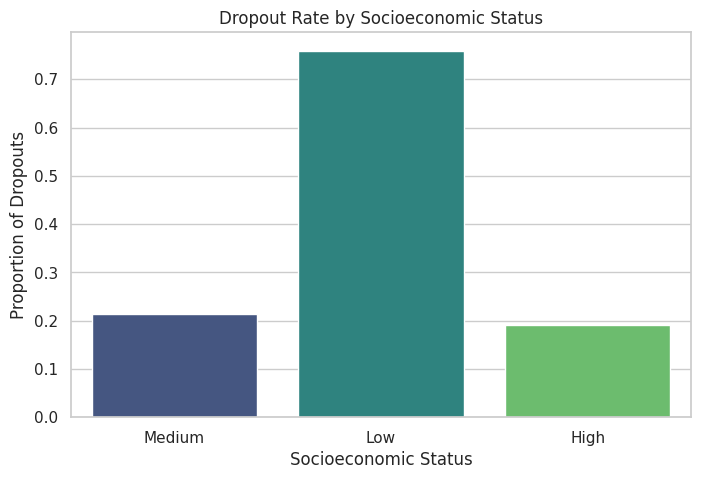

/tmp/ipython-input-12-2949367057.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Gender', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='coolwarm')
/tmp/ipython-input-12-2949367057.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='coolwarm')


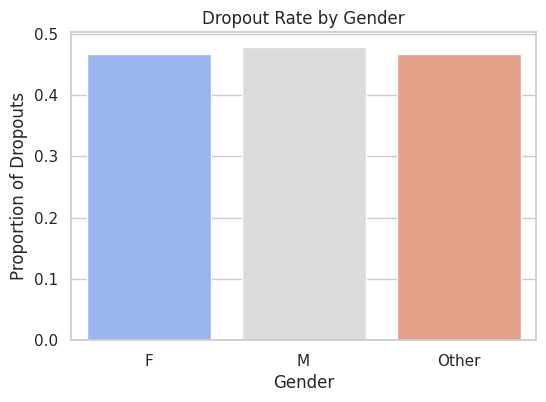

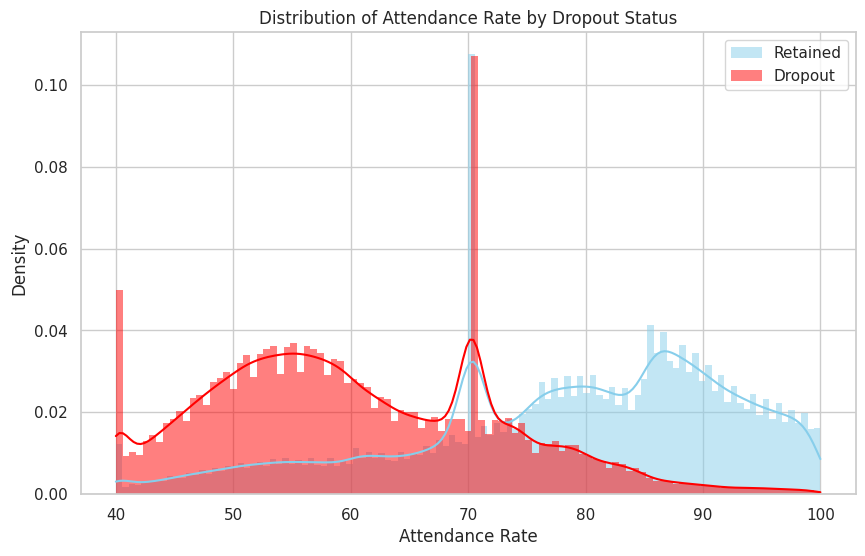

/tmp/ipython-input-12-2949367057.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dropout_Status_Label', y='Previous_Year_GPA', data=df_eda, palette='Set2')


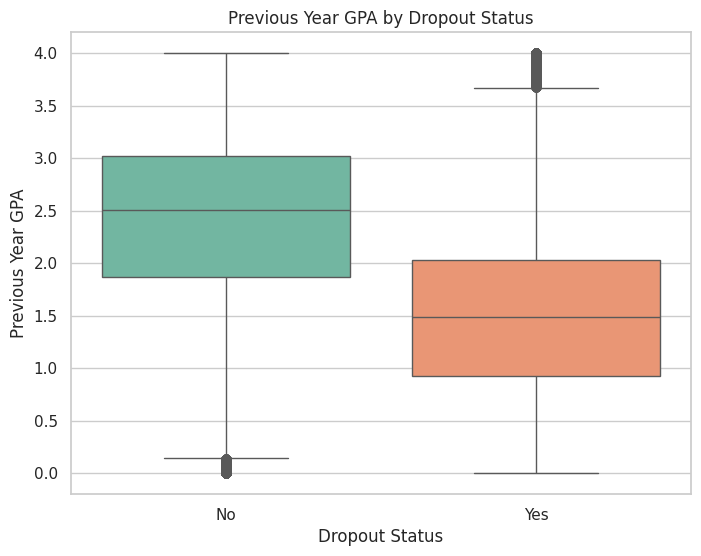

/tmp/ipython-input-12-2949367057.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Location_Type', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='plasma')
/tmp/ipython-input-12-2949367057.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Location_Type', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='plasma')


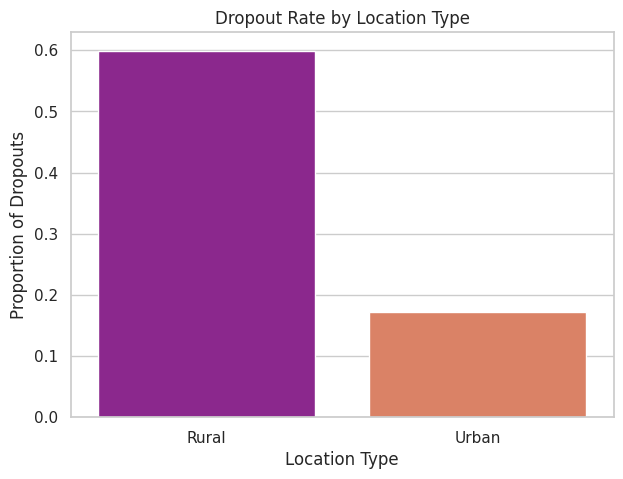

/tmp/ipython-input-12-2949367057.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dropout_rates_by_district.index, y=dropout_rates_by_district.values, palette='viridis')


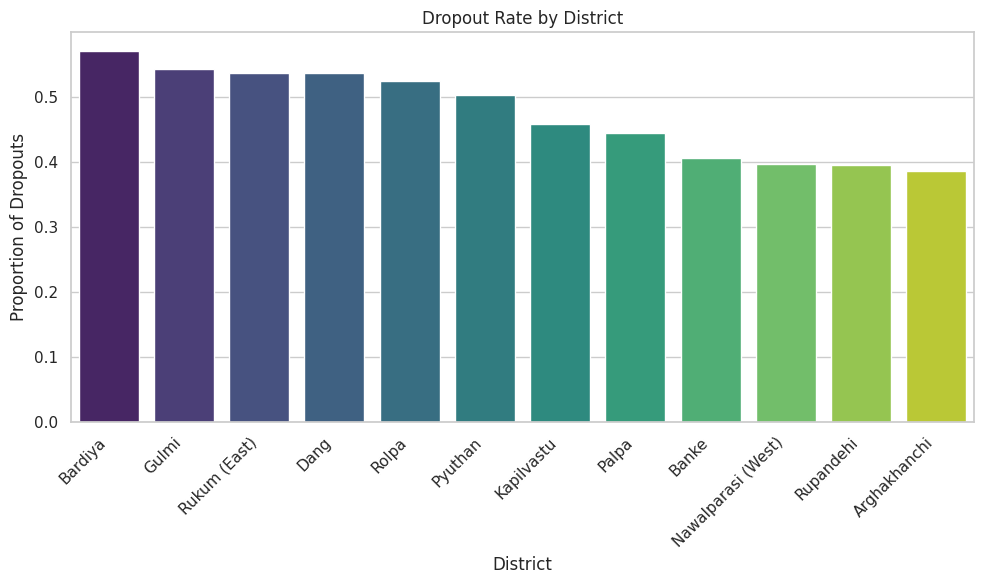

/tmp/ipython-input-12-2949367057.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dropout_Status_Label', y='Infrastructure_Score', data=df_eda, palette='rocket')


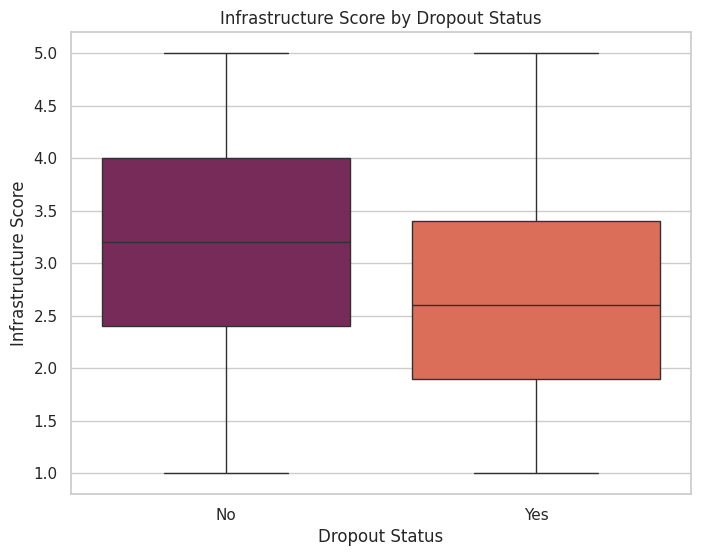

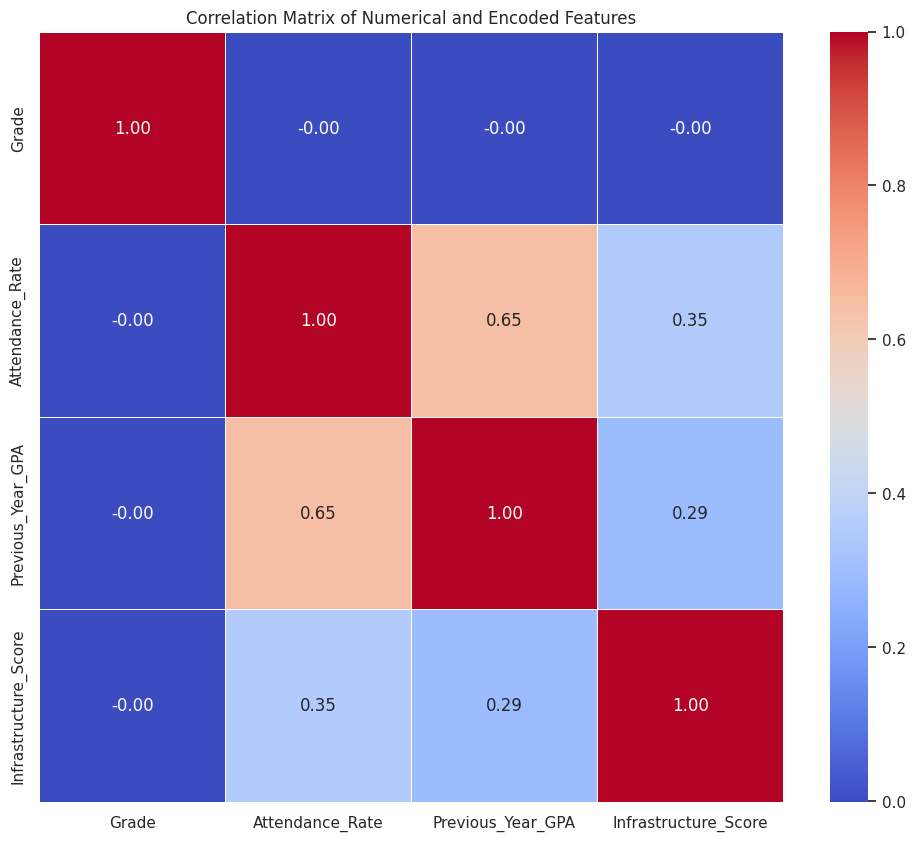

In [ ]:
print("\n--- Performing Exploratory Data Analysis (EDA) ---")

# Set aesthetic style for plots
sns.set_style("whitegrid")

# Create a copy for EDA to avoid modifying the original 'merged_df' for subsequent preprocessing steps.
df_eda = merged_df.copy()

# Map 'Dropout_Status' to 'Yes'/'No' labels for better readability in plots.
df_eda['Dropout_Status_Label'] = df_eda['Dropout_Status'].map({'Y': 'Yes', 'N': 'No'})

# --- Visualizations ---

# 1. Distribution of Student Dropout Status (Bar Plot)
plt.figure(figsize=(6, 4))
sns.countplot(x='Dropout_Status_Label', data=df_eda, palette='pastel')
plt.title('Distribution of Student Dropout Status')
plt.xlabel('Dropout Status')
plt.ylabel('Number of Students')
plt.show()

# 2. Dropout Rate by Socioeconomic Status (Bar Plot)
plt.figure(figsize=(8, 5))
# Calculate proportion of 'Yes' for 'Dropout_Status_Label'
sns.barplot(x='Socioeconomic_Status', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='viridis')
plt.title('Dropout Rate by Socioeconomic Status')
plt.xlabel('Socioeconomic Status')
plt.ylabel('Proportion of Dropouts')
plt.show()

# 3. Dropout Rate by Gender (Bar Plot)
plt.figure(figsize=(6, 4))
sns.barplot(x='Gender', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='coolwarm')
plt.title('Dropout Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion of Dropouts')
plt.show()

# 4. Distribution of Attendance Rate by Dropout Status (Histograms)
plt.figure(figsize=(10, 6))
sns.histplot(df_eda[df_eda['Dropout_Status_Label'] == 'No']['Attendance_Rate'], color="skyblue", label="Retained", kde=True, stat="density", linewidth=0)
sns.histplot(df_eda[df_eda['Dropout_Status_Label'] == 'Yes']['Attendance_Rate'], color="red", label="Dropout", kde=True, stat="density", linewidth=0)
plt.title('Distribution of Attendance Rate by Dropout Status')
plt.xlabel('Attendance Rate')
plt.ylabel('Density')
plt.legend()
plt.show()

# 5. Distribution of Previous Year GPA by Dropout Status (Box Plots)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Dropout_Status_Label', y='Previous_Year_GPA', data=df_eda, palette='Set2')
plt.title('Previous Year GPA by Dropout Status')
plt.xlabel('Dropout Status')
plt.ylabel('Previous Year GPA')
plt.show()

# 6. Dropout Rate by Location Type (Bar Plot)
plt.figure(figsize=(7, 5))
sns.barplot(x='Location_Type', y=(df_eda['Dropout_Status_Label'] == 'Yes').astype(int), data=df_eda, ci=None, palette='plasma')
plt.title('Dropout Rate by Location Type')
plt.xlabel('Location Type')
plt.ylabel('Proportion of Dropouts')
plt.show()

# 7. Dropout Rate by District (Regional Comparison - Bar Plot)
plt.figure(figsize=(10, 6))
# Calculate proportion of 'Yes' for 'Dropout_Status_Label' for each District
dropout_rates_by_district = df_eda.groupby('District')['Dropout_Status_Label'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)
sns.barplot(x=dropout_rates_by_district.index, y=dropout_rates_by_district.values, palette='viridis')
plt.title('Dropout Rate by District')
plt.xlabel('District')
plt.ylabel('Proportion of Dropouts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 8. Infrastructure Score by Dropout Status (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Dropout_Status_Label', y='Infrastructure_Score', data=df_eda, palette='rocket')
plt.title('Infrastructure Score by Dropout Status')
plt.xlabel('Dropout Status')
plt.ylabel('Infrastructure Score')
plt.show()

numeric_cols_for_correlation = [
    'Grade', 'Attendance_Rate', 'Previous_Year_GPA', 'Infrastructure_Score',
    'Gender', 'Socioeconomic_Status', 'District', 'Location_Type',
    'Electricity_Access', 'Internet_Access', 'Library_Status', 'Dropout_Status'
]

# Filter columns that actually exist in merged_df and are numeric
actual_numeric_cols = [col for col in numeric_cols_for_correlation if col in merged_df.columns and pd.api.types.is_numeric_dtype(merged_df[col])]

plt.figure(figsize=(12, 10))
correlation_matrix = merged_df[actual_numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical and Encoded Features')
plt.show()

# --- END OF EDA CODE BLOCK ---

In [ ]:
features = ["Grade", "Gender", "Socioeconomic_Status", "Attendance_Rate", "Previous_Year_GPA",
            "District", "Location_Type", "Infrastructure_Score", "Electricity_Access",
            "Internet_Access", "Library_Status"]
target = "Dropout_Status"

X = df[features]
y = df[target].map({"Y": 1, "N": 0}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
class DropoutDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.3):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Shortcut connection: adjust dimensions if in_features != out_features
        if in_features != out_features:
            self.shortcut = nn.Linear(in_features, out_features)
        else:
            self.shortcut = nn.Identity() # If same dimensions, direct connection

    def forward(self, x):
        residual = x # Store input for residual connection
        out = self.dropout1(F.leaky_relu(self.bn1(self.fc1(x))))
        out = self.dropout2(F.leaky_relu(self.bn2(self.fc2(out))))
        out += self.shortcut(residual) # Add shortcut to output
        return F.leaky_relu(out) # Apply activation after adding residual


class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.dropout_rate = 0.3

        self.initial_layer = nn.Linear(input_size, 256)
        self.initial_bn = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(self.dropout_rate) # <--- THIS LINE WAS MISSING!

        # Residual Blocks
        self.block1 = ResidualBlock(256, 256, self.dropout_rate)
        self.block2 = ResidualBlock(256, 128, self.dropout_rate)
        self.block3 = ResidualBlock(128, 64, self.dropout_rate)
        self.block4 = ResidualBlock(64, 32, self.dropout_rate)

        # Output layer
        self.fc_out = nn.Linear(32, 1) # Output for binary classification

    def forward(self, x):
        x = F.leaky_relu(self.initial_bn(self.initial_layer(x)))
        x = self.dropout(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.fc_out(x)
        return x

In [ ]:
print(f"Type of X just before K-Fold: {type(X)}")
print(f"Shape of X just before K-Fold: {X.shape}") # Add this too for more info

Type of X just before K-Fold: <class 'pandas.core.frame.DataFrame'>
Shape of X just before K-Fold: (600000, 11)



===== Fold 1/5 =====

--- Neural Network Training ---
Neural Network Validation Accuracy for fold 1: 0.7814
NN Classification Report:
               precision    recall  f1-score   support

  No Dropout       0.80      0.77      0.79     63328
     Dropout       0.76      0.79      0.77     56672

    accuracy                           0.78    120000
   macro avg       0.78      0.78      0.78    120000
weighted avg       0.78      0.78      0.78    120000

NN Confusion Matrix:
 [[49077 14251]
 [11979 44693]]


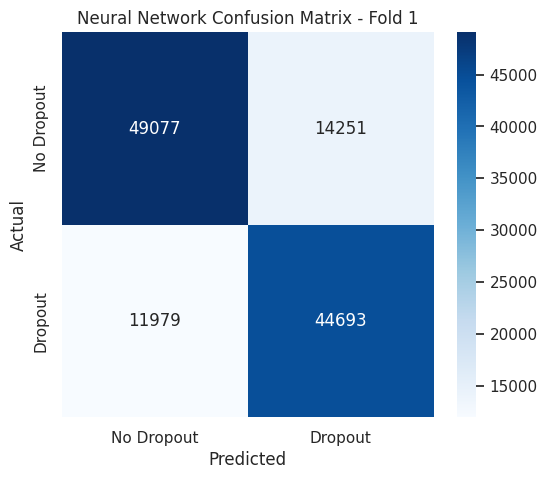


===== Fold 2/5 =====

--- Neural Network Training ---
Neural Network Validation Accuracy for fold 2: 0.7806
NN Classification Report:
               precision    recall  f1-score   support

  No Dropout       0.80      0.78      0.79     63327
     Dropout       0.76      0.78      0.77     56673

    accuracy                           0.78    120000
   macro avg       0.78      0.78      0.78    120000
weighted avg       0.78      0.78      0.78    120000

NN Confusion Matrix:
 [[49700 13627]
 [12706 43967]]


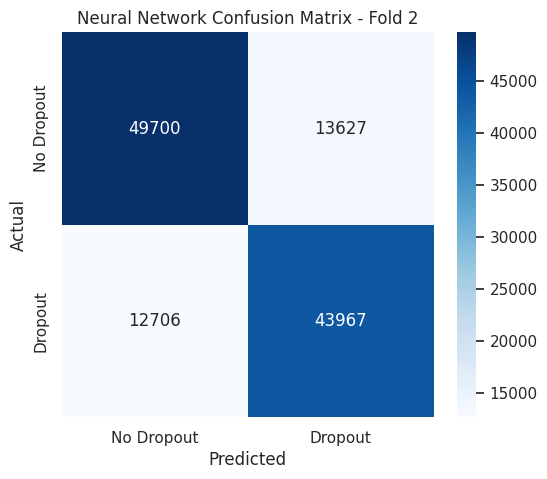


===== Fold 3/5 =====

--- Neural Network Training ---
Neural Network Validation Accuracy for fold 3: 0.7844
NN Classification Report:
               precision    recall  f1-score   support

  No Dropout       0.81      0.77      0.79     63327
     Dropout       0.76      0.80      0.78     56673

    accuracy                           0.78    120000
   macro avg       0.78      0.79      0.78    120000
weighted avg       0.79      0.78      0.78    120000

NN Confusion Matrix:
 [[48856 14471]
 [11404 45269]]


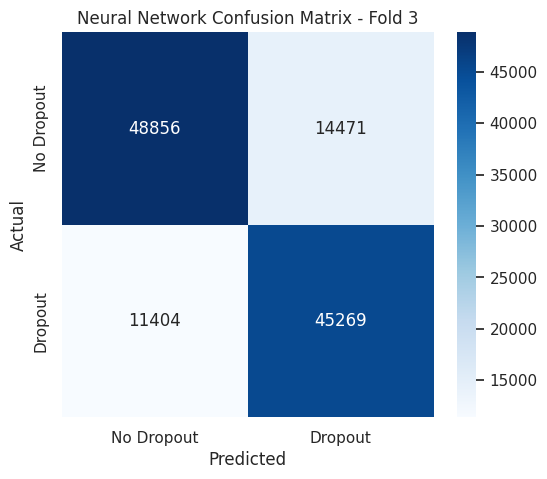


===== Fold 4/5 =====

--- Neural Network Training ---
Neural Network Validation Accuracy for fold 4: 0.7845
NN Classification Report:
               precision    recall  f1-score   support

  No Dropout       0.81      0.77      0.79     63327
     Dropout       0.76      0.80      0.78     56673

    accuracy                           0.78    120000
   macro avg       0.78      0.79      0.78    120000
weighted avg       0.79      0.78      0.78    120000

NN Confusion Matrix:
 [[48650 14677]
 [11183 45490]]


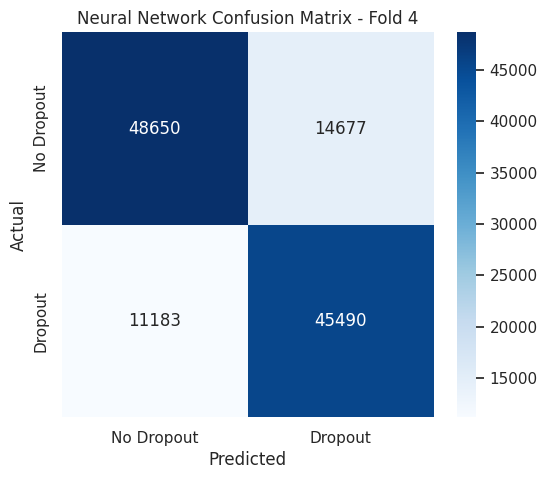


===== Fold 5/5 =====

--- Neural Network Training ---
Neural Network Validation Accuracy for fold 5: 0.7816
NN Classification Report:
               precision    recall  f1-score   support

  No Dropout       0.80      0.79      0.79     63327
     Dropout       0.77      0.77      0.77     56673

    accuracy                           0.78    120000
   macro avg       0.78      0.78      0.78    120000
weighted avg       0.78      0.78      0.78    120000

NN Confusion Matrix:
 [[49919 13408]
 [12801 43872]]


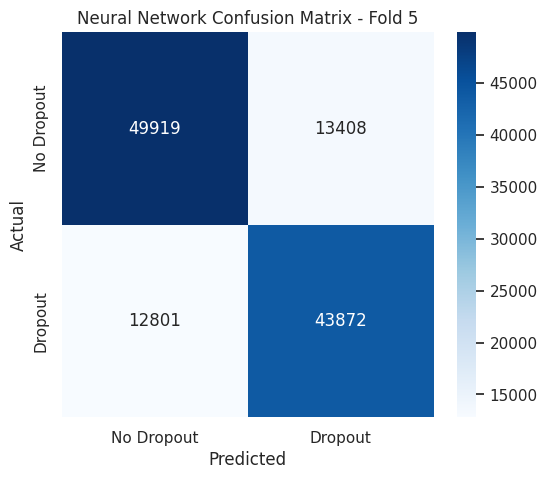


===== K-Fold Cross-Validation Complete =====
Average Neural Network Validation Accuracy: 0.7825 +/- 0.0016


In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to collect results for overall evaluation or eventual stacking
all_nn_val_metrics = []
all_xgb_val_metrics = []
all_true_labels = [] # Collect all true labels for overall reports
all_nn_val_preds_proba = [] # To collect NN probabilities for stacking

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1}/5 =====")

    # 1. Split data for the current fold
    # X remains a DataFrame here, allowing X.iloc to work correctly
    X_train, X_val = X.iloc[train_index], X.iloc[val_index] # Use .iloc
    y_train, y_val = y[train_index], y[val_index]

    # 2. Apply preprocessing pipeline ONLY within the loop
    # This transforms X_train and X_val (DataFrames) into NumPy arrays for model input
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)

    # --- Neural Network Model Training and Evaluation ---
    print("\n--- Neural Network Training ---")
    input_dim = X_train_processed.shape[1] # Input dimension based on preprocessed features
    train_loader = DataLoader(DropoutDataset(X_train_processed, y_train), batch_size=256, shuffle=True)
    val_loader = DataLoader(DropoutDataset(X_val_processed, y_val), batch_size=256)

    nn_model = NeuralNet(input_dim)
    criterion = nn.BCEWithLogitsLoss() # Combines sigmoid and BCE Loss for numerical stability
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

    num_epochs = 10 # You can fine-tune this parameter
    for epoch in range(num_epochs):
        nn_model.train() # Set model to training mode
        for inputs, labels in train_loader:
            optimizer.zero_grad() # Clear gradients
            outputs = nn_model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

    # Neural Network Validation
    nn_model.eval() # Set model to evaluation mode
    nn_preds_proba = [] # Store probabilities
    nn_preds_binary = [] # Store binary predictions
    with torch.no_grad(): # Disable gradient calculation for inference
        for inputs, labels in val_loader:
            outputs = nn_model(inputs)
            probs = torch.sigmoid(outputs) # Convert logits to probabilities
            predicted_binary = (probs > 0.5).float() # Threshold at 0.5
            nn_preds_proba.extend(probs.numpy().flatten())
            nn_preds_binary.extend(predicted_binary.numpy().flatten())

    # Evaluate NN performance for the current fold
    nn_val_accuracy = accuracy_score(y_val, nn_preds_binary)
    all_nn_val_metrics.append(nn_val_accuracy) # Collect accuracy for overall average
    all_nn_val_preds_proba.extend(nn_preds_proba) # Collect probabilities for stacking

    print(f"Neural Network Validation Accuracy for fold {fold+1}: {nn_val_accuracy:.4f}")
    print("NN Classification Report:\n", classification_report(y_val, nn_preds_binary, target_names=['No Dropout', 'Dropout']))
    nn_cm = confusion_matrix(y_val, nn_preds_binary)
    print("NN Confusion Matrix:\n", nn_cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Dropout', 'Dropout'], yticklabels=['No Dropout', 'Dropout'])
    plt.title(f'Neural Network Confusion Matrix - Fold {fold+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



    # Store true labels for overall evaluation or stacking
    all_true_labels.extend(y_val)


# --- Overall Averages After K-Fold Completion ---
print("\n===== K-Fold Cross-Validation Complete =====")
print(f"Average Neural Network Validation Accuracy: {np.mean(all_nn_val_metrics):.4f} +/- {np.std(all_nn_val_metrics):.4f}")